In [ ]:
# Zelle 1: Bibliotheken importieren
import requests
import pandas as pd
from datetime import datetime, timedelta
# import json
import time

print("Bibliotheken erfolgreich importiert!")

Bibliotheken erfolgreich importiert!


In [ ]:
# Zelle 2: Konfiguration und Hilfsfunktionen
# API-Basis-URL
BASE_URL = "https://www.smard.de/app/chart_data"

# Filter-Code für Strompreise (Day-Ahead Auktion)
FILTER_STROMPREIS = 4169

# Region Deutschland
REGION = "DE"

# Auflösung (hour, quarterhour, day, week, month, year)
RESOLUTION = "quarterhour"

def unix_timestamp_ms(dt):
    """Konvertiert datetime zu Unix-Timestamp in Millisekunden"""
    return int(dt.timestamp() * 1000)


def get_available_timestamps(filter_code, region, resolution):
    """
    Ruft verfügbare Timestamps für einen Filter ab
    """
    url = f"{BASE_URL}/{filter_code}/{region}/index_{resolution}.json"
    print(f"Rufe verfügbare Timestamps ab: {url}")
    
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        timestamps = data.get('timestamps', [])
        print(f" {len(timestamps)} verfügbare Zeitstempel gefunden")
        return timestamps
    else:
        print(f" Fehler beim Abrufen der Timestamps: {response.status_code}")
        return []

print("Konfiguration und Hilfsfunktionen geladen!")

Konfiguration und Hilfsfunktionen geladen!


In [3]:
# Zelle 3: Verfügbare Timestamps abrufen
print(f"Filter: {FILTER_STROMPREIS} (Strompreise)")
print(f"Region: {REGION}")
print(f"Auflösung: {RESOLUTION}")
print("-" * 60)

timestamps = get_available_timestamps(FILTER_STROMPREIS, REGION, RESOLUTION)

if timestamps:
    print(f"\nErster Timestamp: {timestamps[0]} ({datetime.fromtimestamp(timestamps[0]/1000)})")
    print(f"Letzter Timestamp: {timestamps[-1]} ({datetime.fromtimestamp(timestamps[-1]/1000)})")
    print(f"\nInsgesamt {len(timestamps)} Zeitstempel verfügbar")


Filter: 4169 (Strompreise)
Region: DE
Auflösung: quarterhour
------------------------------------------------------------
Rufe verfügbare Timestamps ab: https://www.smard.de/app/chart_data/4169/DE/index_quarterhour.json
 369 verfügbare Zeitstempel gefunden

Erster Timestamp: 1538344800000 (2018-10-01 00:00:00)
Letzter Timestamp: 1760911200000 (2025-10-20 00:00:00)

Insgesamt 369 Zeitstempel verfügbar


In [4]:
# Zelle 4: Funktion zum Abrufen der Zeitreihendaten
def get_time_series_data(filter_code, region, resolution, timestamp):
    """
    Ruft Zeitreihendaten für einen bestimmten Timestamp ab
    """
    url = f"{BASE_URL}/{filter_code}/{region}/{filter_code}_{region}_{resolution}_{timestamp}.json"
    
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"✗ Fehler beim Abrufen der Daten für Timestamp {timestamp}: {response.status_code}")
        return None

def parse_time_series(data):
    """
    Parst die Zeitreihendaten in ein DataFrame
    """
    if data and 'series' in data:
        df = pd.DataFrame(data['series'], columns=['timestamp', 'value'])
        df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
        return df
    return pd.DataFrame()

print("Funktionen zum Abrufen der Zeitreihendaten definiert!")


Funktionen zum Abrufen der Zeitreihendaten definiert!


In [14]:
# Zelle 5: Daten für einen bestimmten Zeitraum abrufen
# Beispiel: Daten der letzten 30 Tage abrufen
# (Du kannst die Anzahl der Timestamps anpassen)

# Anzahl der neuesten Timestamps, die abgerufen werden sollen
# NUM_TIMESTAMPS = 5  # Ändere diese Zahl für mehr oder weniger Daten
NUM_TIMESTAMPS = len(timestamps)
print(f"Rufe Daten für die letzten {NUM_TIMESTAMPS} Timestamps ab...")
print("-" * 60)

all_data = []

# Nehme die letzten NUM_TIMESTAMPS Zeitstempel
for idx, ts in enumerate(timestamps[-NUM_TIMESTAMPS:], 1):
    print(f"[{idx}/{NUM_TIMESTAMPS}] Rufe Daten ab für {datetime.fromtimestamp(ts/1000)}")
    
    data = get_time_series_data(FILTER_STROMPREIS, REGION, RESOLUTION, ts)
    
    if data:
        df = parse_time_series(data)
        all_data.append(df)
        print(f"  ✓ {len(df)} Datenpunkte abgerufen")
    
    # Kleine Pause, um die API nicht zu überlasten
    time.sleep(0.5)

print("\n" + "=" * 60)
print("Datenabruf abgeschlossen!")


Rufe Daten für die letzten 369 Timestamps ab...
------------------------------------------------------------
[1/369] Rufe Daten ab für 2018-10-01 00:00:00


SSLError: HTTPSConnectionPool(host='www.smard.de', port=443): Max retries exceeded with url: /app/chart_data/4169/DE/4169_DE_quarterhour_1538344800000.json (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1077)')))

In [10]:
import pandas as pd

# Alle Einzeldatenframes zu einem großen zusammenfügen
df_all = pd.concat(all_data, ignore_index=True)

# Optional: Dubletten nach Zeitstempel entfernen
df_all = df_all.drop_duplicates(subset=["datetime"])

# Speichern als CSV
df_all.to_csv(r"C:\Users\bedla\Documents\Ausbildung_Informatik\1_Praktikum\Praktikum_Daten-_und_Prozessanalyse\energy_trading\Daten\Strompreise_Bundesnetzagentur.csv", index=False, sep=";")

print(f"Strompreise_Bundesnetzagentur.csv")
print(df_all.head())


Strompreise_Bundesnetzagentur.csv
       timestamp  value            datetime
0  1538344800000  59.53 2018-09-30 22:00:00
1  1538345700000  59.53 2018-09-30 22:15:00
2  1538346600000  59.53 2018-09-30 22:30:00
3  1538347500000  59.53 2018-09-30 22:45:00
4  1538348400000  56.10 2018-09-30 23:00:00


In [11]:
# Zelle 6: Daten kombinieren und analysieren
if all_data:
    # Alle DataFrames kombinieren
    df_combined = pd.concat(all_data, ignore_index=True)
    
    # Nach Datum sortieren
    df_combined = df_combined.sort_values('datetime').reset_index(drop=True)
    
    # Duplikate entfernen (falls vorhanden)
    df_combined = df_combined.drop_duplicates(subset=['timestamp'])
    
    print(f"Gesamt: {len(df_combined)} Datenpunkte")
    print(f"Zeitraum: {df_combined['datetime'].min()} bis {df_combined['datetime'].max()}")
    print("\nErste 10 Einträge:")
    print(df_combined.head(10))
    
    # Statistiken
    print("\n" + "=" * 60)
    print("STATISTIKEN")
    print("=" * 60)
    print(f"Durchschnittspreis: {df_combined['value'].mean():.2f} EUR/MWh")
    print(f"Minimaler Preis:    {df_combined['value'].min():.2f} EUR/MWh")
    print(f"Maximaler Preis:    {df_combined['value'].max():.2f} EUR/MWh")
    print(f"Median:             {df_combined['value'].median():.2f} EUR/MWh")
else:
    print("Keine Daten verfügbar!")

Gesamt: 247972 Datenpunkte
Zeitraum: 2018-09-30 22:00:00 bis 2025-10-26 22:45:00

Erste 10 Einträge:
       timestamp  value            datetime
0  1538344800000  59.53 2018-09-30 22:00:00
1  1538345700000  59.53 2018-09-30 22:15:00
2  1538346600000  59.53 2018-09-30 22:30:00
3  1538347500000  59.53 2018-09-30 22:45:00
4  1538348400000  56.10 2018-09-30 23:00:00
5  1538349300000  56.10 2018-09-30 23:15:00
6  1538350200000  56.10 2018-09-30 23:30:00
7  1538351100000  56.10 2018-09-30 23:45:00
8  1538352000000  51.41 2018-10-01 00:00:00
9  1538352900000  51.41 2018-10-01 00:15:00

STATISTIKEN
Durchschnittspreis: 93.31 EUR/MWh
Minimaler Preis:    -500.00 EUR/MWh
Maximaler Preis:    936.28 EUR/MWh
Median:             69.92 EUR/MWh


In [12]:
# Zelle 7: Daten als CSV speichern
if all_data:
    filename = f"strompreise_deutschland_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    df_combined.to_csv(filename, index=False, encoding='utf-8-sig', sep=';')
    print(f"✓ Daten gespeichert in: {filename}")
    print(f"  Anzahl Zeilen: {len(df_combined)}")
    print(f"  Spalten: {', '.join(df_combined.columns)}")


✓ Daten gespeichert in: strompreise_deutschland_20251023_121022.csv
  Anzahl Zeilen: 247972
  Spalten: timestamp, value, datetime


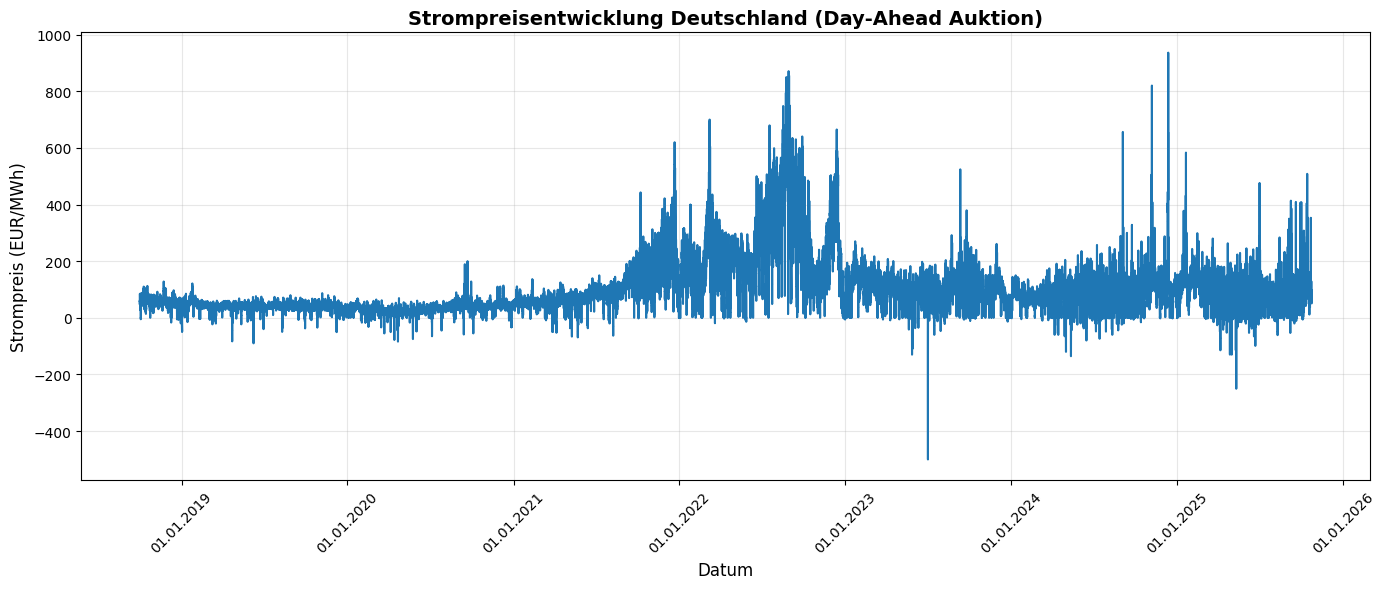

Visualisierung erstellt!


In [ ]:
# Zelle 8: Optional - Visualisierung
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

if all_data:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    ax.plot(df_combined['datetime'], df_combined['value'], linewidth=1.5)
    ax.set_xlabel('Datum', fontsize=12)
    ax.set_ylabel('Strompreis (EUR/MWh)', fontsize=12)
    ax.set_title('Strompreisentwicklung Deutschland (Day-Ahead Auktion)', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Datum-Formatierung auf der x-Achse
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%Y'))
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()